Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/forecasting-beer-remote/auto-ml-forecasting-beer-remote.png)

# AutoML: Train a TCNForecaster (DNN) model on Github Daily Average Users dataset
**Github DAU Forecasting**

**Requirements** - In order to benefit from this tutorial, you will need:
- A basic understanding of Machine Learning
- An Azure account with an active subscription. [Create an account for free](https://azure.microsoft.com/free/?WT.mc_id=A261C142F)
- An Azure ML workspace. [Check this notebook for creating a workspace](../../../resources/workspace/workspace.ipynb) 
- A Compute Cluster. [Check this notebook to create a compute cluster](../../../resources/compute/compute.ipynb)
- A python environment
- Installed Azure Machine Learning Python SDK v2 - [install instructions](../../../README.md) - check the getting started section

**Learning Objectives** - By the end of this tutorial, you should be able to:
- Connect to your AML workspace from the Python SDK
- Create an `AutoML time-series forecasting Job` with the 'forecasting()' factory-fuction.
- Train the model using AmlCompute by submitting/running the AutoML forecasting training job
- Obtaing the model and score predictions with it

**Motivations** - This notebook explains how to setup and run an AutoML forecasting job. This is one of the nine ML-tasks supported by AutoML. Other ML-tasks are 'regression', 'classification', 'image classification', 'image object detection', 'nlp text classification', etc.

In this example we use the associated Github DAU (Daily Average Users) dataset to showcase how you can use AutoML Deep Learning forecasts for a forecasting problem and explore the results. The goal is predict the users for the next 14 days based on historic time-series data.

# 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

## 1.1. Import the required libraries

In [6]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import automl
from azure.ai.ml import Input

## 1.2. Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace. We use the default [default azure authentication](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity.defaultazurecredential?view=azure-python) for this tutorial. Check the [configuration notebook](../../configuration.ipynb) for more details on how to configure credentials and connect to a workspace.

In [ ]:
credential = DefaultAzureCredential()
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group = "<RESOURCE_GROUP>"
    workspace = "<AML_WORKSPACE_NAME>"
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

### Show Azure ML Workspace information

In [ ]:
workspace = ml_client.workspaces.get(name=ml_client.workspace_name)

output = {}
output["Workspace"] = ml_client.workspace_name
output["Subscription ID"] = ml_client.connections._subscription_id
output["Resource Group"] = workspace.resource_group
output["Location"] = workspace.location
output

# 2. Data

The data is stored in a tabular format and includes github active users daily.

With Azure Machine Learning MLTables you can keep a single copy of data in your storage, easily access data during model training, share data and collaborate with other users. 
Below, we will upload the data by creating an MLTable to be used for training.

**NOTE:** In this PRIVATE PREVIEW we're defining the MLTable in a separate folder and .YAML file.
In later versions, you'll be able to do it all in Python APIs.

In [4]:
from helpers.generate_ml_table import create_ml_table

create_ml_table("github_dau_2011-2018_train.csv", "./data/training-mltable-folder")

# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(
    type=AssetTypes.MLTABLE, path="./data/training-mltable-folder"
)

import os
import shutil

os.makedirs("test_dataset", exist_ok=True)
shutil.copy(
    "github_dau_2011-2018_test.csv",
    "test_dataset/github_dau_2011-2018_test.csv",
)

my_test_data_input = Input(
    type=AssetTypes.URI_FOLDER,
    path="test_dataset/",
)

# WITH REMOTE PATH
# my_training_data_input  = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/my-forecasting-mltable")

# 3. Configure and run the AutoML Forecasting training job
In this section we will configure and run the AutoML job, for training the model.

## 3.1 Configure the job through the forecasting() factory function

### forecasting() function parameters:

The `forecasting()` factory function allows user to configure AutoML for the forecasting task for the most common scenarios with the following properties.

- `target_column_name` - The name of the column to target for predictions. It must always be specified. This parameter is applicable to 'training_data', 'validation_data' and 'test_data'.
- `primary_metric` - The metric that AutoML will optimize for model selection.
- `training_data` - The data to be used for training. It should contain both training feature columns and a target column. Optionally, this data can be split for segregating a validation or test dataset. 
You can use a registered MLTable in the workspace using the format '<mltable_name>:<version>' OR you can use a local file or folder as a MLTable. For e.g Input(mltable='my_mltable:1') OR Input(mltable=MLTable(local_path="./data"))
The parameter 'training_data' must always be provided.
- `compute` - The compute on which the AutoML job will run. In this example we are using a compute called 'gpu-nc-compute' present in the workspace. You can replace it any other compute in the workspace. 
- `name` - The name of the Job/Run. This is an optional property. If not specified, a random name will be generated.
- `experiment_name` - The name of the Experiment. An Experiment is like a folder with multiple runs in Azure ML Workspace that should be related to the same logical machine learning experiment.

### set_limits() parameters:
This is an optional configuration method to configure limits parameters such as timeouts.     
    
- timeout_minutes - Maximum amount of time in minutes that the whole AutoML job can take before the job terminates. This timeout includes setup, featurization and training runs but does not include the ensembling and model explainability runs at the end of the process since those actions need to happen once all the trials (children jobs) are done. If not specified, the default job's total timeout is 6 days (8,640 minutes). To specify a timeout less than or equal to 1 hour (60 minutes), make sure your dataset's size is not greater than 10,000,000 (rows times column) or an error results.

- trial_timeout_minutes - Maximum time in minutes that each trial (child job) can run for before it terminates. If not specified, a value of 1 month or 43200 minutes is used.
    
- max_trials - The maximum number of trials/runs each with a different combination of algorithm and hyperparameters to try during an AutoML job. If not specified, the default is 1000 trials. If using 'enable_early_termination' the number of trials used can be smaller.
    
- max_concurrent_trials - Represents the maximum number of trials (children jobs) that would be executed in parallel. It's a good practice to match this number with the number of nodes your cluster.


## 3.2 Specialized Forecasting Parameters
To define forecasting parameters for your experiment training, you can leverage the .set_forecast_settings() method. 
The table below details the forecasting parameters we will be passing into our experiment.

|Property|Description|
|-|-|
|**time_column_name**|The name of your time column.|
|**forecast_horizon**|The forecast horizon is how many periods forward you would like to forecast. This integer horizon is in units of the timeseries frequency (e.g. daily, weekly).|
|**frequency**|Forecast frequency. This optional parameter represents the period with which the forecast is desired, for example, daily, weekly, yearly, etc. Use this parameter for the correction of time series containing irregular data points or for padding of short time series. The frequency needs to be a pandas offset alias. Please refer to [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for more information.
|**label_column_name**|The name of the label column.|

## 3.3 Training Parameters

Some parameters specific to this training job can be set by .set_training() method.

|Property|Description|
|-|-|
|**allowed_training_algorithms**|The algorithms that will be allowed to train. All other models will be blocked.|
|**enable_dnn_training**|Enable Forecasting DNNs|

In [4]:
# general job parameters
compute_name = "gpu-nc-compute"
max_trials = 5
exp_name = "sdkv2-forecasting-github-dau"

target_column_name="count"
forecast_horizon=14
time_column_name="date"


In [12]:
# Create the AutoML forecasting job with the related factory-function.

forecasting_job = automl.forecasting(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    # validation_data = my_validation_data_input,
    target_column_name=target_column_name,
    primary_metric="NormalizedRootMeanSquaredError",
    n_cross_validations=10
)

# Limits are all optional
forecasting_job.set_limits(
    timeout_minutes=600,
    trial_timeout_minutes=30,
    max_trials=max_trials,
    max_concurrent_trials = 4
)

# Specialized properties for Time Series Forecasting training
forecasting_job.set_forecast_settings(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    frequency="D"
)

# Enable Dnn training and allow only TCNForecaster model
forecasting_job.set_training(
    allowed_training_algorithms=["TCNForecaster"],
    enable_dnn_training=True
)


Class ForecastingJob: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


## 3.4 Run the Command
Using the `MLClient` created earlier, we will now run this Command in the workspace.

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    forecasting_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

# 4. Retrieve the Best Trial (Best Model's trial/run)
Use the MLFLowClient to access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Trial.

## 4.1 Initialize MLFlow Client
The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface. 
Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

*IMPORTANT*, you need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow

    pip install mlflow

### Obtain the tracking URI for MLFlow

In [ ]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

In [ ]:
# Set the MLFLOW TRACKING URI

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))

In [11]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

### Get the AutoML parent Job

In [ ]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "funny_soursop_2zpkp35pdy"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

In [ ]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags)

## 4.2 Get the AutoML best child run

In [ ]:
# Get the best model's child run

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

In [ ]:
import pandas as pd

pd.DataFrame(best_run.data.metrics, index=[0]).T

## 4.3 Download the best model locally

Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [16]:
# Create local folder
import os

local_dir = "./artifact_downloads"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [ ]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print("Artifacts downloaded in: {}".format(local_path))
print("Artifacts: {}".format(os.listdir(local_path)))

In [ ]:
# Show the contents of the MLFlow model folder
os.listdir("./artifact_downloads/outputs")

## 5. Forecasting using batch endpoint
Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. We will do batch scoring on the test dataset which should have the same schema as training dataset.

The inference will run on a remote compute. In this example, it will re-use the training compute. Fisrt we will load model and environment from the local file.

### Create a model endpoint
First we need to register the model, environment and batch endpoint.

In [22]:
from azure.ai.ml.entities import (
    Environment,
    BatchEndpoint,
    BatchDeployment,
    BatchRetrySettings,
    Model,
)
from azure.ai.ml.constants import BatchDeploymentOutputAction

model_name = "github-dau-tcn"
batch_endpoint_name = model_name+"-batch"

model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/model.pt",
    name=model_name,
    description="Github DAU forecasting",
)
registered_model = ml_client.models.create_or_update(model)

env = Environment(
    name="automl-tabular-env-tcn",
    description="environment for automl TCN inference",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.1-cudnn8-ubuntu18.04:20220930.v1",
    conda_file="artifact_downloads/outputs/conda_env_v_1_0_0.yml",
)

endpoint = BatchEndpoint(
    name=batch_endpoint_name,
    description="this is a sample batch endpoint",
)

In [ ]:
ml_client.begin_create_or_update(endpoint)

Create a batch deployment we will use the forecasting_script.py which will load the model and will call forecast each time we will envoke the endpoint.

In [20]:
output_file = "forecast.json"
batch_deployment = BatchDeployment(
    name="non-mlflow-deployment",
    description="this is a sample non-mlflow deployment",
    endpoint_name=batch_endpoint_name,
    model=registered_model,
    code_path="./helpers",
    scoring_script="forecasting_script.py",
    environment=env,
    environment_variables={
        "TARGET_COLUMN_NAME": target_column_name,
    },
    compute="gpu-nc-compute",
    instance_count=1,
    max_concurrency_per_instance=2,
    mini_batch_size=10,
    output_action=BatchDeploymentOutputAction.APPEND_ROW,
    output_file_name=output_file,
    retry_settings=BatchRetrySettings(max_retries=3, timeout=30),
    logging_level="info",
)

Finally, start a model deployment.

In [ ]:
ml_client.begin_create_or_update(batch_deployment)

We need to create the Input, representing URI folder, because the batch endpoint is intended to process multiple files at a time. In this example we will use only one test file, we have uploaded to the blob storage before. This file must be available through the url link.

Create an inference job.

In [22]:
job = ml_client.batch_endpoints.invoke(
    endpoint_name=batch_endpoint_name,
    input=my_test_data_input,
    deployment_name="non-mlflow-deployment",  # name is required as default deployment is not set
)

We will stream the job output to monitor the execution.

In [ ]:
job_name = job.name
batch_job = ml_client.jobs.get(name=job_name)
print(batch_job.status)
# stream the job logs
ml_client.jobs.stream(name=job_name)

### Download the prediction result for metrics calculation
The output of prediction is saved in JSON format. You can download it and calculation some error metrics for the forecasts and vizualize the predictions vs. the actuals.

In [ ]:
ml_client.jobs.download(job_name, download_path=".")

In [25]:
fcst_df = pd.read_json(output_file, orient="table")
fcst_df.head()

,date,day_of_week,month_of_year,holiday,count,predicted
58,2017-08-01,1.0,7.0,0.0,158477,144066.265625
59,2017-08-02,2.0,7.0,0.0,159089,152318.250000
60,2017-08-03,3.0,7.0,0.0,157182,152173.640625
61,2017-08-04,4.0,7.0,0.0,146345,149625.765625
62,2017-08-05,5.0,7.0,0.0,92534,137934.343750


Calculate the metrics.

In [27]:
from helpers.metrics_helper import calculate_metrics

calculate_metrics(fcst_df[target_column_name], fcst_df["predicted"])

,metric name,score
0,R2 score,0.115920
1,mean absolute error,22145.982205
2,mean_absolute_percentage_error,15.102107
3,root mean squared error,32245.721381
4,normalized root mean squared error,0.236800


### Forecast versus actuals plot.

We will plot the forecasts with the actuals

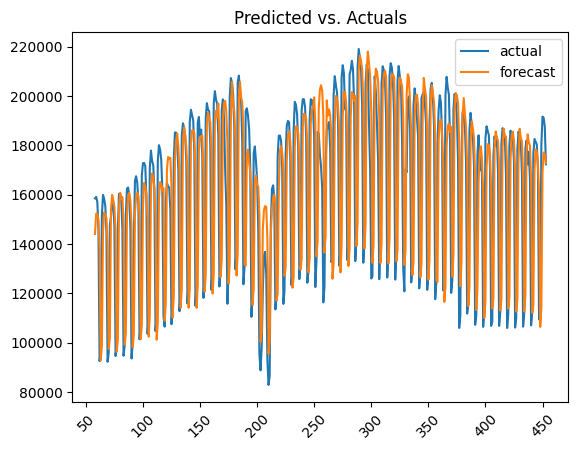

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(fcst_df[[target_column_name, "predicted"]])
plt.xticks(rotation=45)
plt.title(f"Predicted vs. Actuals")
plt.legend(["actual", "forecast"])
plt.show()

In [ ]:
# Delete the batch endpoint and compute. Do not do it occasionally.
ml_client.batch_endpoints.begin_delete(name=batch_endpoint_name)
# ml_client.compute.begin_delete(name=)

# Next Step: Load the best model and try predictions

Loading the models locally assume that you are running the notebook in an environment compatible with the model. The list of dependencies that is expected by the model is specified in the MLFlow model produced by AutoML (in the 'conda.yaml' file within the mlflow-model folder).

Since the AutoML model was trained remotelly in a different environment with different dependencies to your current local conda environment where you are running this notebook, if you want to load the model you have several options:

1. A recommended way to locally load the model in memory and try predictions is to create a new/clean conda environment with the dependencies specified in the conda.yml file within the outputs folder and refer helpers/forecasting_script.py for details on how to load a pytorch model

2. You can install all the packages/dependencies specified in conda.yml into your current conda environment you used for using Azure ML SDK and AutoML. MLflow SDK also have a method to install the dependencies in the current environment. However, this option could have risks of package version conflicts depending on what's installed in your current environment.


# Next Steps
You can see further examples of other AutoML tasks such as Image-Classification, Image-Object-Detection, NLP-Text-Classification, Time-Series-Forcasting, etc.